# Regression 2

In [36]:
import functions

import os
import scipy.io
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# for clustering
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

# for statistical tests
from scipy.stats import ttest_rel, ttest_ind
from statsmodels.stats.multitest import multipletests

from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler

In [15]:
import importlib
importlib.reload(functions)

<module 'functions' from '/Users/maylismuller/Desktop/EPFL_DOCS/Master/MA4/Project Hummel/uphummel_MA4/functions.py'>

## Loading the data

In [16]:
excel_folder_path = "data/"
FM_folder_path = "data/Raw_MissingDataImputed/"
regression_info, rsfMRI_full_info = functions.load_excel_data(excel_folder_path, FM_folder_path)
folder_path = "FC_matrices_times_wp11/"

rois = [363, 364, 365, 368, 372, 373, 374, 377, 379, 361, 370, 362, 371, 12, 54, 56, 78, 96, 192, 234, 236, 258, 276, 8, 9, 51, 52, 53, 188, 189, 231, 232, 233]
rois = [roi - 1 for roi in rois]
rois_sub = rois
rois_full = np.arange(0, 379)
selected_rois = [362, 363, 364, 367, 371, 372, 373, 376]
striatum_labels = [
    'Caudate_ipsi', 'Putamen_ipsi', 'Caudate_contra', 'Putamen_contra', 'Pallidum_ipsi', 'Pallidum_contra', 
    'Accumbens_ipsi', 'Accumbens_contra'
]

striatum_labels = [
    'Caudate_ipsi', 'Putamen_ipsi', 'Caudate_contra', 'Putamen_contra', 'Pallidum_ipsi', 'Pallidum_contra', 
    'Accumbens_ipsi', 'Accumbens_contra'
]
all_matrices, all_subjects, yeo_mat_all_rois, roi_mapping_yeo = functions.load_matrices(folder_path, rsfMRI_full_info, rois, request_type='all', plot=False)
t1_t3_t4_matched = all_matrices.copy().dropna(subset=['T1_matrix', 'T3_matrix', 'T4_matrix'])

roi_mapping = functions.load_roi_labels("data/HCP-MMP1_RegionsCorticesList_379.csv")  # adapt path

Trying to load: TiMeS_matrix_mdImputed_allT4.xlsx
✅ Successfully loaded: TiMeS_matrix_mdImputed_allT4.xlsx
Trying to load: TiMeS_matrix_mdImputed_allT3.xlsx
✅ Successfully loaded: TiMeS_matrix_mdImputed_allT3.xlsx
Trying to load: TiMeS_matrix_mdImputed_allT2.xlsx
✅ Successfully loaded: TiMeS_matrix_mdImputed_allT2.xlsx
Trying to load: TiMeS_matrix_mdImputed_allT1.xlsx
✅ Successfully loaded: TiMeS_matrix_mdImputed_allT1.xlsx


In [17]:
df_aligned, regression_info = functions.switch_contra_ipsi_df(
    t1_t3_t4_matched, 
    regression_info, 
    tp=3, 
    rois=rois, 
    roi_mapping=roi_mapping
)
df_L, df_R = functions.split_by_lesion_side(t1_t3_t4_matched)
print(f"{len(df_L)} left-lesioned subjects")
print(f"{len(df_R)} right-lesioned subjects")
df_aligned_L_T3 = functions.switch_contra_ipsi_df(
    df_L, 
    regression_info, 
    tp=3, 
    rois=rois, 
    roi_mapping=roi_mapping
)

df_aligned_R_T3 = functions.switch_contra_ipsi_df(
    df_R, 
    regression_info, 
    tp=3, 
    rois=rois, 
    roi_mapping=roi_mapping
)

df_aligned_L_T4 = functions.switch_contra_ipsi_df(
    df_L, 
    regression_info, 
    tp=4, 
    rois=rois, 
    roi_mapping=roi_mapping
)

df_aligned_R_T4 = functions.switch_contra_ipsi_df(
    df_R, 
    regression_info, 
    tp=4, 
    rois=rois, 
    roi_mapping=roi_mapping
)

8 left-lesioned subjects
17 right-lesioned subjects


In [18]:
print(f"Number of subjects with T1, T3, and T4 matrices, and without undefined stroke lesion side: {len(df_aligned)}")
print("Number of predictors: ", len(rois)-1) # I drop Brainstem, as not defined as L or R

Number of subjects with T1, T3, and T4 matrices, and without undefined stroke lesion side: 25
Number of predictors:  32


In [19]:
def keep_selected_rows(mat, selected_rois):
    if mat is None:
        return None
    return mat.loc[selected_rois, :]

t1_t3_t4_matched_sel = df_aligned.copy()

for col in ['T1_matrix', 'T3_matrix', 'T_matrix']:
    if col in df_aligned.columns:
        t1_t3_t4_matched_sel[col] = df_aligned[col].apply(lambda mat: keep_selected_rows(mat, striatum_labels))

selected_col = 'T1_matrix'
tp = 1

# Step 4: Merge with motor scores
regression_t = regression_info[
    (regression_info["TimePoint"] == f"T{tp}") &
    (regression_info["Behavioral_assessment"] == 1) &
    (regression_info["MRI"] == 1)
].copy()

valid_data = t1_t3_t4_matched_sel.merge(
        regression_t[["subject_id", "nmf_motor", "Fugl_Meyer_contra", "Fugl_Meyer_ipsi"]],
        on="subject_id"
    )

In [20]:
print(f"Number of subjects with T1, T3, and T4 matrices, and without undefined stroke lesion side: {len(valid_data)}")

Number of subjects with T1, T3, and T4 matrices, and without undefined stroke lesion side: 25


In [21]:
X = np.array([fc.values.flatten() for fc in valid_data[selected_col]]) 

# Example matrix from one subject
example_fc = valid_data[selected_col].iloc[0]  # shape (8, 33)

# Extract row and column labels
row_labels = example_fc.index.tolist()
col_labels = example_fc.columns.tolist()

# Create ROIxROI feature names
feature_names = [f"{row}|{col}" for row in row_labels for col in col_labels]

X_df = pd.DataFrame(X, columns=feature_names)  # No scaling
X_df_clean = X_df.dropna(axis=1) # Shape: (n_subjects=25, 8×32 - diagonal values that are nan = 248)

param_grid = {
    "rfe__n_features_to_select": [5, 10, 17, 18, 19, 20, 21, 22, 23, 24, 30, 40, 80, 160, X_df_clean.shape[1]]
}

In [22]:
print("X_df_clean shape:", X_df_clean.shape)
print("Any NaNs?:", X_df_clean.isnull().values.any())
print("Max/Min/Std per feature:", X_df_clean.describe().T[['mean', 'std']])

X_df_clean shape: (25, 248)
Any NaNs?: False


Max/Min/Std per feature:                                                     mean       std
Caudate_ipsi|Putamen_ipsi                       0.206684  0.302451
Caudate_ipsi|Pallidum_ipsi                      0.095186  0.169559
Caudate_ipsi|Accumbens_ipsi                     0.014392  0.144203
Caudate_ipsi|Cerebellu_ipsi                     0.152811  0.178173
Caudate_ipsi|Thalamus_ipsi                      0.417588  0.301969
...                                                  ...       ...
Accumbens_contra|Primary_Motor_Cortex_contra   -0.031660  0.312794
Accumbens_contra|Primary_Sensory_Cortex_contra -0.080445  0.277180
Accumbens_contra|Area_1_contra                 -0.109857  0.309560
Accumbens_contra|Area_2_contra                 -0.120452  0.286974
Accumbens_contra|Area_3a_contra                -0.063959  0.270952

[248 rows x 2 columns]


NB: As there are 8 diagonal values, 8 columns will be full of empty data

## Ridge Regression

### Modeling Rationale: RFE, Ridge Regression, and R² Scoring

To predict motor behavior from functional connectivity (FC) features, we used a modeling pipeline combining **Recursive Feature Elimination (RFE)**, **Ridge Regression**, and **R² scoring**, selected based on the nature of our data and the goals of the analysis.

#### Why RFE?
**Recursive Feature Elimination (RFE)** is a wrapper-based feature selection method that iteratively removes the least informative features based on model performance. This is particularly important in neuroimaging datasets, where:

- The number of features (e.g., FC links) often exceeds the number of subjects.
- Many features are noisy or redundant.
- We seek interpretability: RFE helps identify a **compact, informative subset** of brain connections most predictive of motor outcomes.

#### Why Ridge Regression?
We used **Ridge regression** (ℓ2-regularized linear regression) because:

- It handles **high-dimensional data** well, where standard linear regression would overfit.
- It is robust to **multicollinearity**, which is common in brain connectivity data (many FC features are correlated).
- It regularizes coefficient estimates, improving model generalization without forcing sparsity (unlike Lasso).

#### Why R² Scoring?
We evaluated model performance using **R² (coefficient of determination)** because:

- It quantifies how much variance in the motor outcome is explained by the model.
- It is scale-invariant and interpretable: e.g., an R² of 0.6 means 60% of the variance is explained.
- It is standard in regression analysis and particularly useful for comparing predictive performance across models and feature sets.

---

Together, this pipeline provides a statistically sound, interpretable, and generalizable approach for linking FC features to behavioral outcomes.


### Fuegl-Meyer Ipsi

In [23]:
y_FMI = valid_data['Fugl_Meyer_ipsi'].values
selected_feature_names_FMI, grid_FMI = functions.run_Ridge_with_RFE(X_df_clean, y_FMI, param_grid)

Best number of features: 22
Best cross-validated R² score: -3.0894609584707
Top predictive features:
                                  Feature    Weight
8           Caudate_contra|Cerebellu_ipsi -0.395529
12          Caudate_contra|Area_3a_contra -0.377755
13          Pallidum_ipsi|Pallidum_contra -0.297753
10  Caudate_contra|Area_6_anterior_contra  0.296191
6            Putamen_ipsi|Thalamus_contra  0.290914
1     Caudate_ipsi|Area_6_anterior_contra  0.280625
19    Pallidum_contra|Rostral_Area_6_ipsi -0.279131
5        Putamen_ipsi|Rostral_Area_6_ipsi -0.275475
21         Accumbens_contra|Area_2_contra  0.257924
7             Caudate_contra|Putamen_ipsi  0.247685


R² on full data: 0.998
Mean Squared Error: 0.008
Mean Absolute Error: 0.073


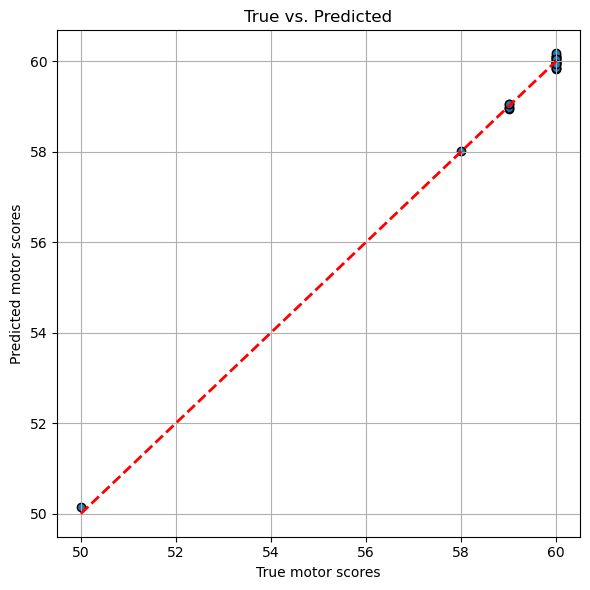

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Step 1: Predict with the best model on all data
y_pred_FMI = grid_FMI.best_estimator_.predict(X_df_clean)

# Step 2: Evaluate performance
r2_FMI = r2_score(y_FMI, y_pred_FMI)
mse_FMI = mean_squared_error(y_FMI, y_pred_FMI)
mae_FMI = mean_absolute_error(y_FMI, y_pred_FMI)

print(f"R² on full data: {r2_FMI:.3f}")
print(f"Mean Squared Error: {mse_FMI:.3f}")
print(f"Mean Absolute Error: {mae_FMI:.3f}")

plt.figure(figsize=(6, 6))
plt.scatter(y_FMI, y_pred_FMI, edgecolor='k')
plt.plot([y_FMI.min(), y_FMI.max()], [y_FMI.min(), y_FMI.max()], 'r--', lw=2)
plt.xlabel("True motor scores")
plt.ylabel("Predicted motor scores")
plt.title("True vs. Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()


SEVERE OVERFITTING

##### Try for power law

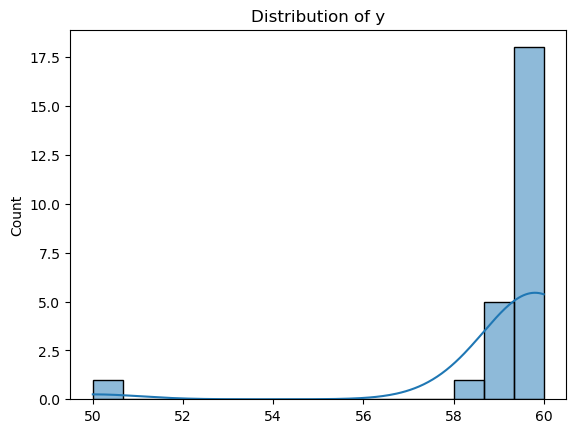

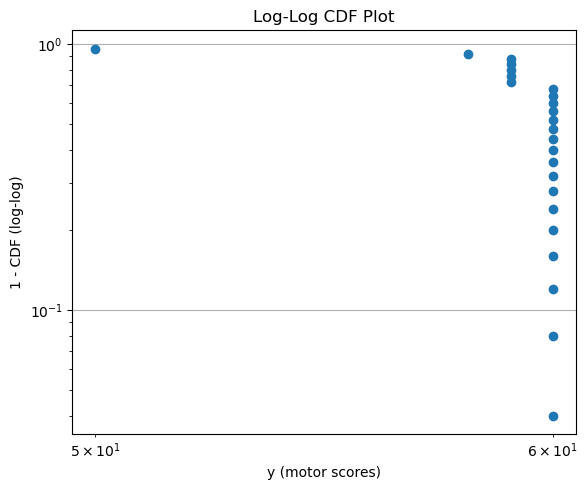

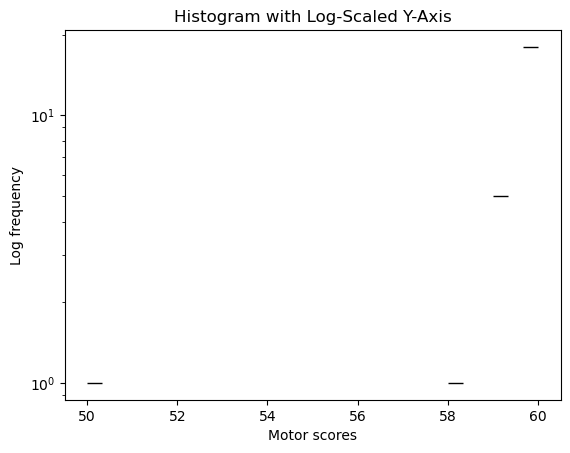

In [26]:
sns.histplot(y_FMI, kde=True)
plt.title("Distribution of y")
plt.show()

import numpy as np
import matplotlib.pyplot as plt

y_sorted_FMI = np.sort(y_FMI)
cdf_FMI = 1.0 - np.arange(1, len(y_sorted_FMI) + 1) / len(y_sorted_FMI)

plt.figure(figsize=(6, 5))
plt.loglog(y_sorted_FMI, cdf_FMI, marker='o', linestyle='none')
plt.xlabel("y (motor scores)")
plt.ylabel("1 - CDF (log-log)")
plt.title("Log-Log CDF Plot")
plt.grid(True)
plt.tight_layout()
plt.show()

sns.histplot(y_FMI, bins=30, log_scale=(False, True))
plt.title("Histogram with Log-Scaled Y-Axis")
plt.xlabel("Motor scores")
plt.ylabel("Log frequency")
plt.show()

In [27]:
import numpy as np

# Shift y if needed to avoid log(0)
y_transformed_FMI = np.log1p(y_FMI)  # log(1 + y)

# Use in your model
selected_feature_names_FMI, grid_FMI = functions.run_Ridge_with_RFE(X_df_clean, y_transformed_FMI, param_grid)

Best number of features: 23
Best cross-validated R² score: -3.559561316375042
Top predictive features:
                                   Feature    Weight
7            Caudate_contra|Cerebellu_ipsi -0.009011
2               Caudate_ipsi|Area_2_contra  0.005236
4         Putamen_ipsi|Rostral_Area_6_ipsi -0.005224
0      Caudate_ipsi|Area_6_anterior_contra  0.004799
13     Pallidum_ipsi|Ventral_Area_6_contra  0.004713
10            Caudate_contra|Area_1_contra  0.003960
19      Pallidum_contra|Dorsal_area_6_ipsi -0.003888
20     Pallidum_contra|Rostral_Area_6_ipsi -0.003724
22  Pallidum_contra|Area_6_anterior_contra  0.003613
6              Caudate_contra|Putamen_ipsi  0.003556


### Fugl-Meyer Contra

In [28]:
y_FMC = valid_data['Fugl_Meyer_contra'].values
selected_feature_names_FMC, grid_FMC = functions.run_Ridge_with_RFE(X_df_clean, y_FMC, param_grid)

Best number of features: 248
Best cross-validated R² score: -50.86339173369834
Top predictive features:
                                   Feature    Weight
162     Pallidum_contra|Dorsal_area_6_ipsi -1.353802
176        Pallidum_contra|Area_55b_contra  1.290326
157          Pallidum_contra|Pallidum_ipsi  1.257903
141          Pallidum_ipsi|Pallidum_contra  1.257903
160          Pallidum_contra|Thalamus_ipsi  1.162825
179  Pallidum_contra|Rostral_Area_6_contra -1.080304
194     Accumbens_ipsi|Rostral_Area_6_ipsi  0.980654
177   Pallidum_contra|Dorsal_area_6_contra  0.950879
36              Putamen_ipsi|Area_55b_ipsi  0.931138
17            Caudate_ipsi|Pallidum_contra  0.906376


R² on full data: 1.000
Mean Squared Error: 0.025
Mean Absolute Error: 0.108


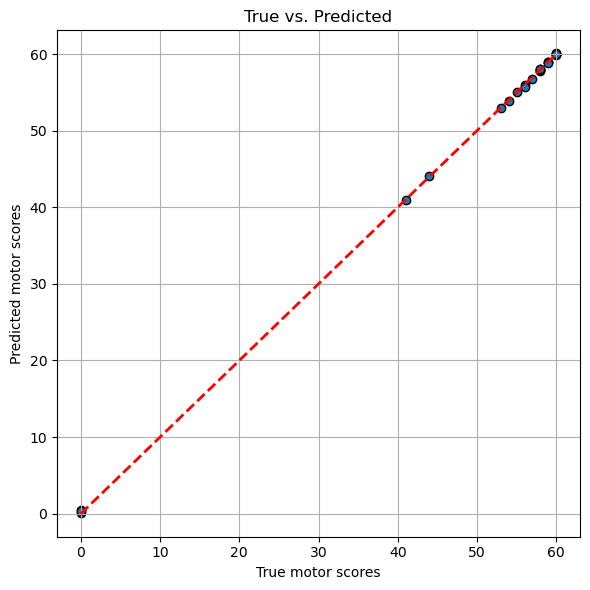

In [29]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Step 1: Predict with the best model on all data
y_pred_FMC = grid_FMC.best_estimator_.predict(X_df_clean)

# Step 2: Evaluate performance
r2 = r2_score(y_FMC, y_pred_FMC)
mse = mean_squared_error(y_FMC, y_pred_FMC)
mae = mean_absolute_error(y_FMC, y_pred_FMC)

print(f"R² on full data: {r2:.3f}")
print(f"Mean Squared Error: {mse:.3f}")
print(f"Mean Absolute Error: {mae:.3f}")

plt.figure(figsize=(6, 6))
plt.scatter(y_FMC, y_pred_FMC, edgecolor='k')
plt.plot([y_FMC.min(), y_FMC.max()], [y_FMC.min(), y_FMC.max()], 'r--', lw=2)
plt.xlabel("True motor scores")
plt.ylabel("Predicted motor scores")
plt.title("True vs. Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()


##### Try for power law

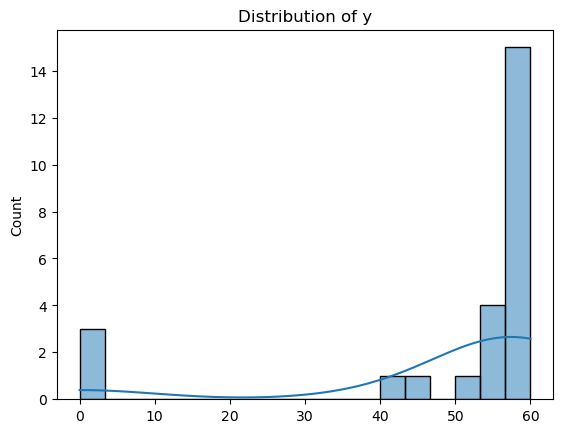

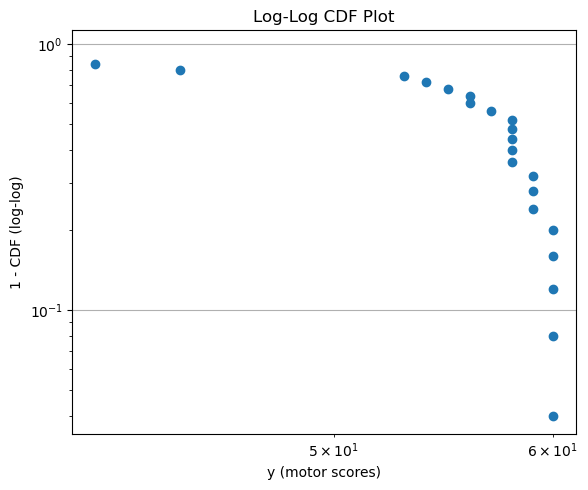

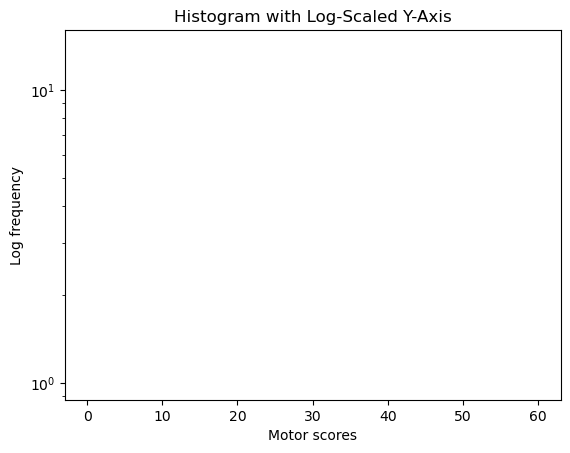

In [30]:
sns.histplot(y_FMC, kde=True)
plt.title("Distribution of y")
plt.show()

import numpy as np
import matplotlib.pyplot as plt

y_sorted_FMC = np.sort(y_FMC)
cdf_FMC = 1.0 - np.arange(1, len(y_sorted_FMC) + 1) / len(y_sorted_FMC)

plt.figure(figsize=(6, 5))
plt.loglog(y_sorted_FMC, cdf_FMC, marker='o', linestyle='none')
plt.xlabel("y (motor scores)")
plt.ylabel("1 - CDF (log-log)")
plt.title("Log-Log CDF Plot")
plt.grid(True)
plt.tight_layout()
plt.show()

sns.histplot(y_FMC, bins=30, log_scale=(False, True))
plt.title("Histogram with Log-Scaled Y-Axis")
plt.xlabel("Motor scores")
plt.ylabel("Log frequency")
plt.show()

In [31]:
import numpy as np

# Shift y if needed to avoid log(0)
y_transformed_FMC = np.log1p(y_FMC)  # log(1 + y)

# Use in your model
selected_feature_names_FMC, grid_FMC = functions.run_Ridge_with_RFE(X_df_clean, y_transformed_FMC, param_grid)

Best number of features: 248
Best cross-validated R² score: -895.4649020282714
Top predictive features:
                                   Feature    Weight
162     Pallidum_contra|Dorsal_area_6_ipsi -0.104493
176        Pallidum_contra|Area_55b_contra  0.095582
141          Pallidum_ipsi|Pallidum_contra  0.095261
157          Pallidum_contra|Pallidum_ipsi  0.095261
160          Pallidum_contra|Thalamus_ipsi  0.084090
194     Accumbens_ipsi|Rostral_Area_6_ipsi  0.083860
179  Pallidum_contra|Rostral_Area_6_contra -0.082275
177   Pallidum_contra|Dorsal_area_6_contra  0.077484
36              Putamen_ipsi|Area_55b_ipsi  0.077302
113         Putamen_contra|Thalamus_contra -0.066517


### nmf motor

In [ ]:
y_nmf = valid_data['nmf_motor'].values
#selected_feature_names_nmf, grid_nmf = functions.run_Ridge_with_RFE(X_df_clean, y_nmf, param_grid)
valid_data

##### Test for power law

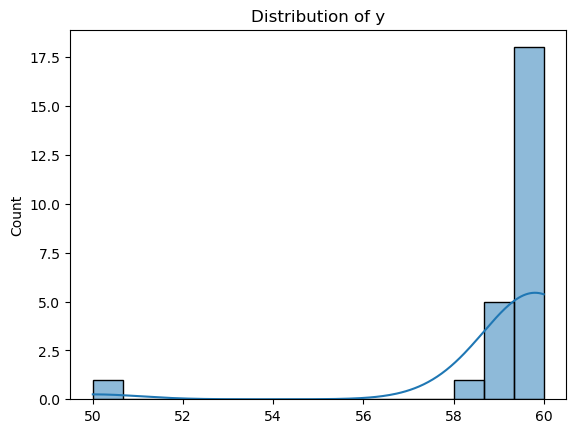

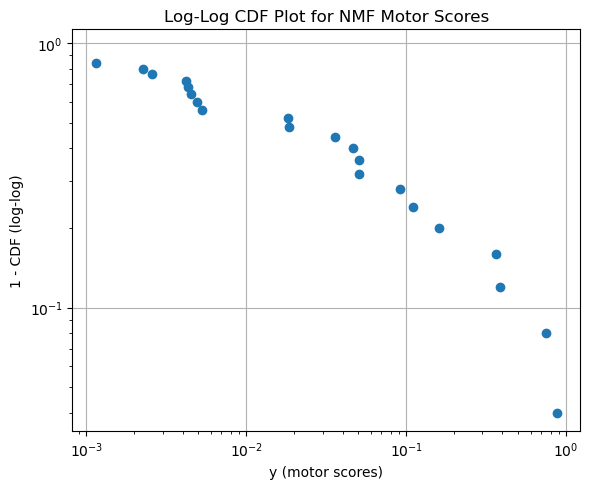

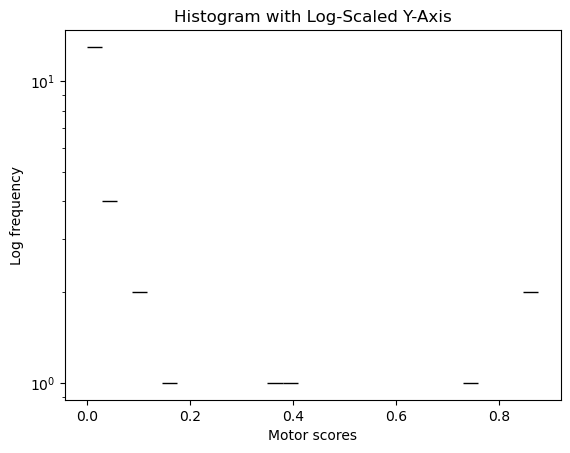

array([0.0918348 , 0.15952088, 0.05049405, 0.00417791, 0.0184514 ,
       0.00528117, 0.75103937, 0.01831653, 0.0043415 , 0.00258406,
       0.05105313, 0.        , 0.00492996, 0.03607847, 0.        ,
       0.38541573, 0.0011431 , 0.36238876, 0.04645568, 0.87606081,
       0.0045482 , 0.        , 0.87606081, 0.11109711, 0.00225755])

In [43]:
sns.histplot(y, kde=True)
plt.title("Distribution of y")
plt.show()

import numpy as np
import matplotlib.pyplot as plt

y_sorted_nmf = np.sort(y_nmf)
cdf_nmf = 1.0 - np.arange(1, len(y_sorted_nmf) + 1) / len(y_sorted_nmf)

plt.figure(figsize=(6, 5))
plt.loglog(y_sorted_nmf, cdf_nmf, marker='o', linestyle='none')
plt.xlabel("y (motor scores)")
plt.ylabel("1 - CDF (log-log)")
plt.title("Log-Log CDF Plot for NMF Motor Scores")
plt.grid(True)
plt.tight_layout()
plt.show()

sns.histplot(y_nmf, bins=30, log_scale=(False, True))
plt.title("Histogram with Log-Scaled Y-Axis")
plt.xlabel("Motor scores")
plt.ylabel("Log frequency")
plt.show()
y_nmf

NB: Here, low sample (25) with high predictors (256), and y is skewed ! Looks like a power law

In [34]:
import numpy as np

# Shift y if needed to avoid log(0)
y_transformed_nmf = np.log1p(y_nmf)  # log(1 + y)

# Use in your model
selected_feature_names_nmf, grid_nmf = functions.run_Ridge_with_RFE(X_df_clean, y_transformed_nmf, param_grid)

Best number of features: 248
Best cross-validated R² score: -308.3986934485603
Top predictive features:
                                Feature    Weight
176     Pallidum_contra|Area_55b_contra -0.012505
141       Pallidum_ipsi|Pallidum_contra -0.011431
157       Pallidum_contra|Pallidum_ipsi -0.011431
40    Putamen_ipsi|Area_6_anterior_ipsi  0.010387
160       Pallidum_contra|Thalamus_ipsi -0.009983
136           Pallidum_ipsi|Area_1_ipsi -0.009814
17         Caudate_ipsi|Pallidum_contra -0.009705
155        Pallidum_contra|Caudate_ipsi -0.009705
61          Putamen_ipsi|Area_3a_contra  0.009699
162  Pallidum_contra|Dorsal_area_6_ipsi  0.009672


## Random Forest Regression

### Fuegl-Meyer Ipsi

In [37]:
# Pipeline: standardize, then fit Random Forest
pipe = Pipeline([
    ("scaler", StandardScaler()),  # optional, not always needed for RF
    ("rf", RandomForestRegressor(n_estimators=100, random_state=42))
])

# Cross-validation
cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)
scores = cross_val_score(pipe, X_df_clean, y_FMI, cv=cv, scoring='r2')
print("Random Forest R² (CV):", scores.mean())


Random Forest R² (CV): -2.376115263003278


### Fuegl-Meyer Contra

In [38]:
# Pipeline: standardize, then fit Random Forest
pipe = Pipeline([
    ("scaler", StandardScaler()),  # optional, not always needed for RF
    ("rf", RandomForestRegressor(n_estimators=100, random_state=42))
])

# Cross-validation
cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)
scores = cross_val_score(pipe, X_df_clean, y_FMC, cv=cv, scoring='r2')
print("Random Forest R² (CV):", scores.mean())


Random Forest R² (CV): -24.33943135239661


### nmf motor

In [39]:
# Pipeline: standardize, then fit Random Forest
pipe = Pipeline([
    ("scaler", StandardScaler()),  # optional, not always needed for RF
    ("rf", RandomForestRegressor(n_estimators=100, random_state=42))
])

# Cross-validation
cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)
scores = cross_val_score(pipe, X_df_clean, y_nmf, cv=cv, scoring='r2')
print("Random Forest R² (CV):", scores.mean())


Random Forest R² (CV): -281.07140852335374
